# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [82]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2025_silver/ingresos_membresia_1_dia_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-25 00:00:00 a 2024-12-31 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,136.88,2022-07-25,136.88
1,3,354.00,2022-07-28,354.00
2,2,236.00,2022-07-29,236.00
3,9,1062.00,2022-08-02,1062.00
4,2,236.00,2022-08-08,236.00


Filtro para obtener muestra de datos

In [83]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [84]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.05,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [85]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1240 2025-12-27
1241 2025-12-28
1242 2025-12-29
1243 2025-12-30
1244 2025-12-31


Paso 5: Realizar la Predicción (Forecast)

In [86]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds           yhat    yhat_lower     yhat_upper
1240 2025-12-27   52295.783302  28385.499532   73656.450975
1241 2025-12-28  111876.076338  84051.830744  138856.573629
1242 2025-12-29   22299.890336     32.457398   43063.471740
1243 2025-12-30   20638.480476  -1514.877891   43987.213468
1244 2025-12-31   20249.764916  -3082.509400   41031.741278


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

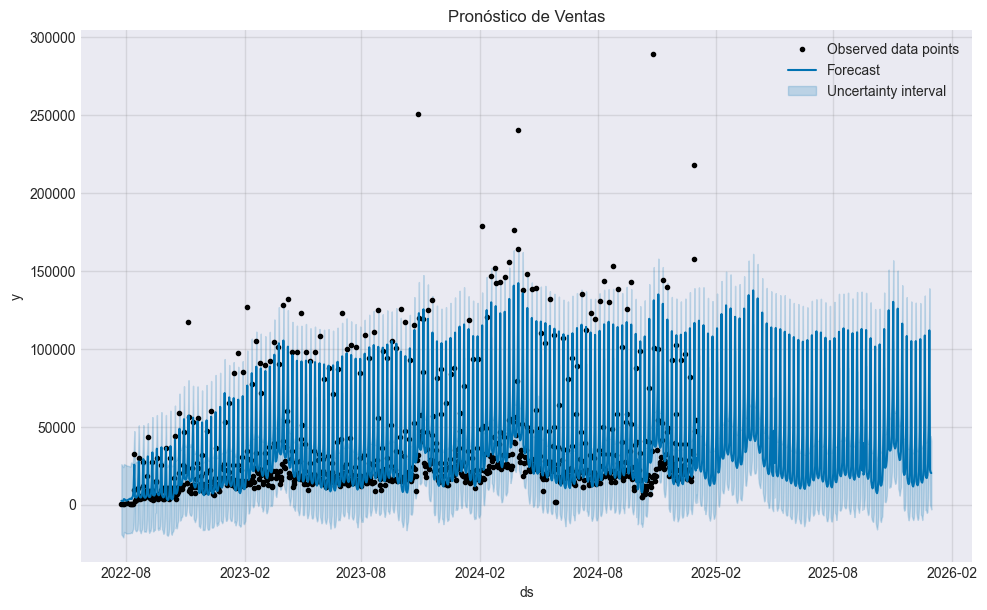

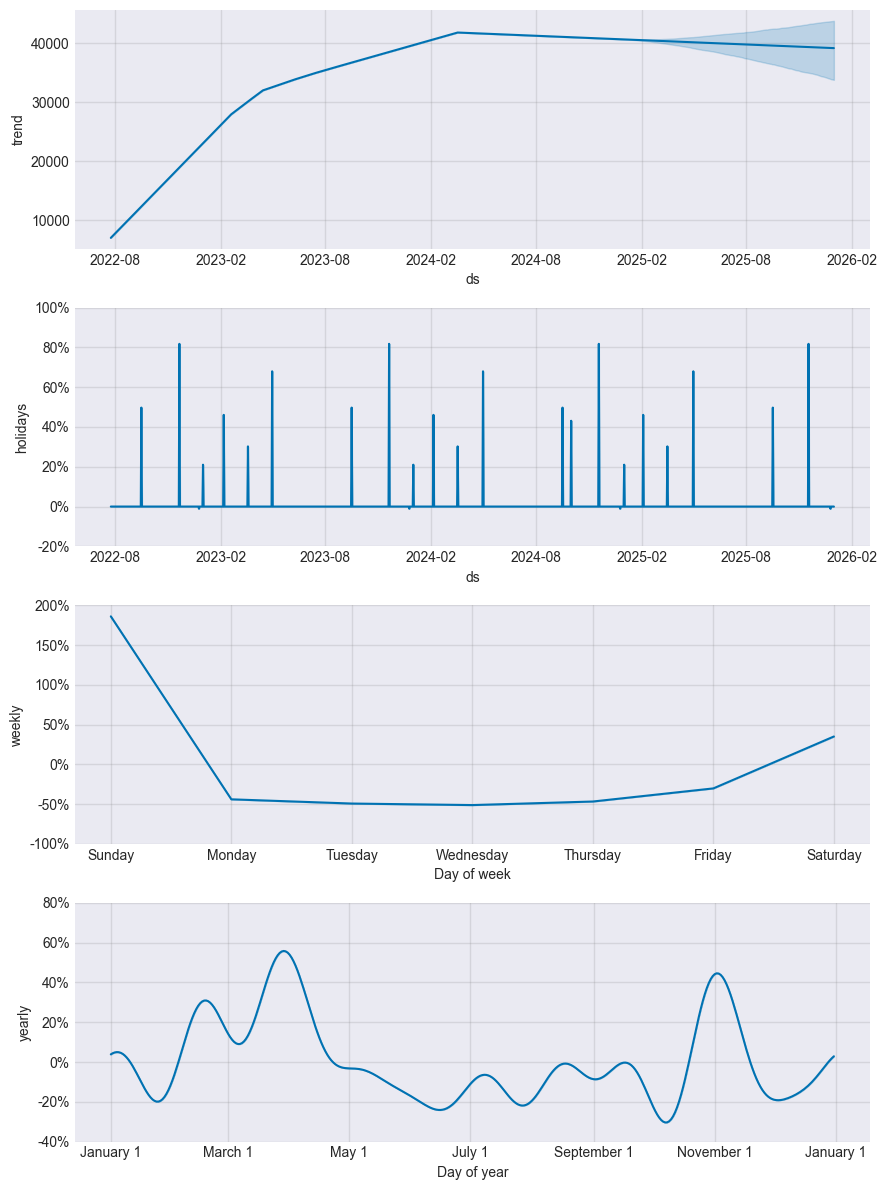

In [87]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [88]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month        yhat  yhat_lower  yhat_upper
0   2022-07     8365.96   -57669.43    76061.97
1   2022-08   206195.94  -318996.63   735960.87
2   2022-09   340891.61  -325677.07  1003572.74
3   2022-10   492324.81  -193711.39  1176556.90
4   2022-11   617080.62   -44928.16  1279696.00
5   2022-12   579764.04  -115301.09  1270771.53
6   2023-01   728841.48    40507.37  1416085.69
7   2023-02   922549.00   303668.11  1537545.74
8   2023-03  1168736.08   483281.05  1858233.92
9   2023-04  1212757.43   551562.61  1881452.68
10  2023-05   914336.66   218446.45  1596706.60
11  2023-06   785941.15   118060.77  1454402.46
12  2023-07   999220.06   315802.06  1683268.96
13  2023-08   980672.83   291684.18  1662050.62
14  2023-09  1052181.22   389075.01  1711333.00
15  2023-10  1150956.51   462285.25  1827228.01
16  2023-11  1300480.42   632941.74  1962771.96
17  2023-12  1147232.50   443139.50  1841783.56
18  2024-01  1100124.75   409102.45  1780284.17
19  2024-02  1394775.73   758993.81  203

In [89]:
monthly_sales.to_csv("../data/data_forecast_2025_gold/forecast_1_dia_2025_monthly.csv")

In [90]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/1 [00:00<?, ?it/s]11:20:15 - cmdstanpy - INFO - Chain [1] start processing
11:20:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


  horizon          rmse      mape
0  9 days  11555.065400  0.971246
1 10 days  17604.209586  1.323652
2 11 days  32679.587768  1.545537
3 12 days  32874.958524  1.773963
4 13 days  32600.390298  1.915498
